In [1]:
%matplotlib widget
import os
import glob
import numpy as np
from pint import UnitRegistry
from scipy.ndimage import gaussian_filter1d
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colorbar import Colorbar
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import warnings
from PIL import Image
from typing import Union
import h5py

In [2]:
ureg = UnitRegistry()

In [3]:
def get_folder_contents(folder_path, display_contents=False):
    files = glob.glob(os.path.join(folder_path, "*"))

    #Display file names
    if(display_contents):
        for file in files:
            print(file)
        
    return files

In [4]:
# Creates a library containing data in the following format
# name_root
# timestamp
# duration
# vdc_adc
#   size0
#   size1
#   units
# first_var
#   var_name
#   min
#   max
#   pts
#   units
def parse_txt_file(filepath, logging=False):
    global ureg
    
    scans_information = []
    
    with open(filepath) as txt_file:
        file_line = txt_file.readline()
        while file_line.strip():
            [name_root, timestamp, first_var_str, vdc_adc_str, _, delay_str, _] = file_line.split("\t")
            
            if(logging):
                print("Filename:  " + str(name_root))
                print("Timestamp: " + str(timestamp))
                print("First Var: " + str(first_var_str))
                print("vdc_adc: " + str(vdc_adc_str))
                print("Delay:     " + str(delay_str))
                print()
            
            # Parse first_var
            try:
                first_var = {}
                first_var["var_name"] = first_var_str.split("=")[0]
                first_var["min"] = float(first_var_str.split("->")[0].split("=")[-1])
                first_var["max"] = float(first_var_str.split("->")[1].split("(")[0])
                first_var["pts"] = int(first_var_str.split("(")[-1].split("pts)")[0])
                first_var["units"] = ureg(first_var_str.split("[")[-1][:-1])
            except Exception as e:
                print("Error parsing \"scan \" in " + str(filepath))
                raise Exception("Error Parsing Delay")
            
            # Parse Vdc_adc
            try:
                if(vdc_adc_str.split("=")[0] != "Vdc_adc"):
                    raise Exception("Var Name Incorrect")
                vdc_adc_str = vdc_adc_str.replace("Vdc_adc=", "")
                vdc_adc_str = vdc_adc_str.split("[")
                if(len(vdc_adc_str) != 4):
                    raise Exception("Vdc_adc format wrong")
                vdc_adc = {}
                vdc_adc["size0"], vdc_adc["size1"] = [int(num) for num in vdc_adc_str[2][:-1].split("x")]
                vdc_adc["dac_min"] = float(vdc_adc_str[1].split("(")[1].split("->")[0])
                vdc_adc["dac_max"] = float(vdc_adc_str[1].split(")")[0].split("->")[1])
                vdc_adc["units"] = ureg(vdc_adc_str[3][:-1])
            except Exception as e:
                print("Error parsing \"vdc_adc \" in " + str(filepath))
                raise Exception("Error Parsing vdc_adc")
                
            # Parse Delay
            try:
                if(delay_str.split("=")[0] != "delay"):
                    raise Exception("Var Name Incorrect")
                delay = ureg(delay_str.split("=")[1])
            except Exception as e:
                print("Error parsing \"delay\" in " + str(filepath))
                raise Exception("Error Parsing Delay")
            
            #Build and store the information for this line in the text file (1 scan)
            scan_information = {}
            scan_information["name_root"] = name_root.replace(".DAT", "")
            scan_information["timestamp"], scan_information["duration"] = timestamp.split(" ")
            scan_information["vdc_adc"] = vdc_adc
            scan_information["delay"] = delay
            scan_information["first_var"] = first_var
            scans_information.append(scan_information)
            
            file_line = txt_file.readline()
            
    return scans_information

In [5]:
# Returns an array containing scan entries with the following structure (started from parse_txt_file() )
# []
#   name_root
#   timestamp
#   duration
#   first_var
#     var_name
#     min
#     max
#     pts
#     units
#   vdc_adc
#     size0
#     size1
#     units
#   traces []
#     IV_trace, [float]
def parse_scan_folder(raw_data_folder, logging=False):
    global ureg
    print("Starting extraction of scan data from: " + str(raw_data_folder) + "\n")
    if(raw_data_folder[-1] != "\\"):
          raw_data_folder = raw_data_folder + "\\"

    data_filepaths = get_folder_contents(raw_data_folder, logging)
    for entity_path in data_filepaths:

        #Parse file/folder name from path
        entity_name = entity_path.replace("\\\\", "\\").replace(raw_data_folder, "")

        #Don't scan directories recursively, TODO: This could be implemented
        if(os.path.isdir(raw_data_folder + entity_name)):
            continue

        if(entity_name.split(".")[-1] == "txt"):
            scans_information = parse_txt_file(raw_data_folder +entity_name, logging)

    # traces
    # params
    for scan in scans_information:
        print("Analyzing: " + scan["name_root"])
        with open(raw_data_folder + scan["name_root"] + ".DAT") as scan_data:
            with open(raw_data_folder + scan["name_root"] + ".Vdc_adc.DAT") as trace_data:
                param_strs = scan_data.readline().split(",")[:-1]
                param_units = [ureg(unit_str) for unit_str in scan_data.readline().split(",")[:-1]]
                traces = []
                for trace_num in range(scan["vdc_adc"]["size0"]):
                    trace_params = scan_data.readline()
                    trace = {}
                    for param_i, param in enumerate(param_strs):
                        trace[param] = float(trace_params.split(",")[param_i])*param_units[param_i]
                    trace["IV_trace"] = [float(num_str) for num_str in trace_data.readline().split(",")[:]]
                    traces.append(trace)
        scan["traces"] = traces
    print("\nFinished extraction of scan data from: " + str(raw_data_folder) + "\n")
    return scans_information

In [6]:
def calculate_ic_trace(scan, threshold, logging=True):
    if(logging):
        print("Calculating Ic for: " + scan["name_root"])

    ic_neg_vals = []
    ic_pos_vals = []
    
    currents = np.linspace(scan["vdc_adc"]["dac_min"], scan["vdc_adc"]["dac_max"], scan["vdc_adc"]["size1"])
    zero_index = np.argmin(np.abs(currents))
    for trace_num in range(scan["vdc_adc"]["size0"]):    
        
        voltages = scan["traces"][trace_num]["IV_trace"]
        voltages = voltages-np.average(voltages) #Shfit voltages to center at zero

        ic_neg = currents[np.argmin(voltages[:zero_index] < -threshold)]
        ic_pos = currents[np.argmax(voltages[zero_index:] > threshold)+zero_index]

        # Min of a true false matrix. checks if entire range is above threshold and sets to be zero
        if(min(voltages[:zero_index] < -threshold)):
            ic_neg = currents[zero_index]
        
        ic_neg_vals.append(ic_neg)    
        ic_pos_vals.append(ic_pos)
    return ic_neg_vals, ic_pos_vals

In [7]:
def init_fraunhover(filepath, x_vals, y_vals, c_vals, s, custom_cmap):
    fig_temp, ax_temp = plt.subplots()
    ax_temp.scatter(x_vals, y_vals, c=c_vals, s=s, cmap=custom_cmap)
    xlim = ax_temp.get_xlim()
    ylim = ax_temp.get_ylim()
#     ax_temp.set_xlim(min(x_vals), max(x_vals))
#     ax_temp.set_ylim(min(y_vals), max(y_vals))
    ax_temp.axis('off')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    fig_temp.savefig(filepath, bbox_inches='tight', pad_inches=0)
    plt.close(fig_temp)
    
    #Make white border transparent
    image = Image.open(filepath).convert('RGBA')
    image_data = image.getdata()
    new_image_data = []
    for pixel in image_data:
        if pixel[:3] == (255, 255, 255):  # For strictly white pixels
            # To be more inclusive of near-white shades, you can adjust this check
            # For example: if item[0] > 240 and item[1] > 240 and item[2] > 240:
            new_image_data.append((255, 255, 255, 0))  # Keep the color but set alpha to 0
        else:
            new_image_data.append(pixel)  # Otherwise, keep the original color
    image.putdata(new_image_data)
    image.save(filepath, 'PNG')
    
    return xlim, ylim, filepath

def plot_scan_var_iv(scan, plot_derivatives=True, plot_ic_trace=True, threshold=0.01, fig=None, ax=None, logging=True):
    if(logging):
        print("Plotting: " + scan["name_root"])

    applied_first_vars = np.linspace(scan["first_var"]["min"], scan["first_var"]["max"], scan["first_var"]["pts"])
    x_vals = []
    y_vals = []
    c_vals = []
    currents = np.linspace(scan["vdc_adc"]["dac_min"], scan["vdc_adc"]["dac_max"], scan["vdc_adc"]["size1"])
    plot_filepath = os.getcwd() + "/plots/base_fraunhofer/" + scan["name_root"] + ".png"
    if(not(os.path.exists(plot_filepath)) or not("fraunhofer_filepath" in scan)):
        for trace_num in range(len(applied_first_vars)):
            # print(scan)
            voltages = scan["traces"][trace_num]["IV_trace"]

            smoothing_sigma=10
            dv_di = np.gradient(gaussian_filter1d(voltages, sigma=smoothing_sigma), currents)

            x_vals = np.concatenate((x_vals, applied_first_vars[trace_num] * np.ones(len(dv_di))))
            y_vals = np.concatenate((y_vals, currents))
            c_vals = np.concatenate((c_vals, dv_di))

    if(plot_ic_trace):
        ic_neg, ic_pos = calculate_ic_trace(scan, threshold, logging=logging)
    if(logging):
        print("Generating Plot")
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["white", "blue", "darkblue", "midnightblue", "red", "darkred"])
    
    if(fig == None):
        fig, ax = plt.subplots()
        fig.colorbar(ScalarMappable(norm=mcolors.Normalize(0, 1), cmap=custom_cmap),
             ax=ax, orientation='vertical', label='dv_di [arb units]')
#     scatter = ax.scatter(x_vals, y_vals, c=c_vals, s=1, cmap=custom_cmap)
    if(not(os.path.exists(plot_filepath)) or not("fraunhofer_filepath" in scan)):
        scan["fraunhofer_xlim"], scan["fraunhofer_ylim"], scan["fraunhofer_filepath"] = init_fraunhover(plot_filepath, x_vals, y_vals, c_vals, s=2, custom_cmap=custom_cmap)
    xlim=scan["fraunhofer_xlim"]
    ylim=scan["fraunhofer_ylim"]
    ax.imshow(plt.imread(scan["fraunhofer_filepath"]), extent=[xlim[0], xlim[1], ylim[0], ylim[1]], aspect='auto')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(scan["name_root"])
    ax.set_xlabel(scan["first_var"]["var_name"] + " [" + str(scan["first_var"]["units"].units) + "]")
    ax.set_ylabel("Vdc_adc [" + str(scan["vdc_adc"]["units"].units) + "]")
    
    #Adjust x axis to mT if given in tesla
    if(str(scan["first_var"]["units"].units) == "tesla"):
        def x_axis_to_mT(val, pos):
            return f'{val * 1000:.1f}'
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(x_axis_to_mT))
    ax.set_xlabel(scan["first_var"]["var_name"] + " [mT]")
        
    
    if(plot_ic_trace):
        ic_neg_plot, = ax.plot(applied_first_vars, ic_neg, color="black")
        ic_pos_plot, = ax.plot(applied_first_vars, ic_pos, color="black")
    else:
        ic_neg_plot = None
        ic_pos_plot = None
        
    plot_elements = [ic_neg_plot, ic_pos_plot]
    return fig, ax, plot_elements

def plot_scan_var_iv_split(scan_top, scan_bottom, plot_derivatives=True, plot_ic_trace=True, threshold=0.01, fig=None, ax=None, logging=True):
    if(logging):
        print("Plotting: " + scan_top["name_root"] + " and " + scan_bottom["name_root"])

    applied_first_vars_top = np.linspace(scan_top["first_var"]["min"], scan_top["first_var"]["max"], scan_top["first_var"]["pts"])
    applied_first_vars_bottom = np.linspace(scan_bottom["first_var"]["min"], scan_bottom["first_var"]["max"], scan_bottom["first_var"]["pts"])
    currents_top = np.linspace(scan_top["vdc_adc"]["dac_min"], scan_top["vdc_adc"]["dac_max"], scan_top["vdc_adc"]["size1"])
    currents_bottom = np.linspace(scan_bottom["vdc_adc"]["dac_min"], scan_bottom["vdc_adc"]["dac_max"], scan_bottom["vdc_adc"]["size1"])
    
    plot_filepath_top = os.getcwd() + "/plots/base_fraunhofer/" + scan_top["name_root"] + "_top.png"
    if(not(os.path.exists(plot_filepath_top)) or scan_top["fraunhofer_filepath_top"] is None):
        x_vals_top = []
        y_vals_top = []
        c_vals_top = []
        for trace_num in range(len(applied_first_vars_top)):
            # print(scan)
            voltages = scan_top["traces"][trace_num]["IV_trace"]

            smoothing_sigma=10
            dv_di = np.gradient(gaussian_filter1d(voltages, sigma=smoothing_sigma), currents_top)

            iv_mask = (currents_bottom>=0)
            
            x_vals_top = np.concatenate((x_vals_top, np.array(applied_first_vars_top[trace_num] * np.ones(len(dv_di)))[iv_mask]))
            y_vals_top = np.concatenate((y_vals_top, currents_top[iv_mask]))
            c_vals_top = np.concatenate((c_vals_top, dv_di[iv_mask]))
            
    plot_filepath_bottom = os.getcwd() + "/plots/base_fraunhofer/" + scan_bottom["name_root"] + "_bottom.png"
    if(not(os.path.exists(plot_filepath_bottom)) or scan_bottom["fraunhofer_filepath_bottom"] is None):
        x_vals_bottom = []
        y_vals_bottom = []
        c_vals_bottom = []
        for trace_num in range(len(applied_first_vars_bottom)):
            # print(scan)
            voltages = scan_bottom["traces"][trace_num]["IV_trace"]

            smoothing_sigma=10
            dv_di = np.gradient(gaussian_filter1d(voltages, sigma=smoothing_sigma), currents_bottom)
            iv_mask = (currents_bottom<0)
            
            x_vals_bottom = np.concatenate((x_vals_bottom, np.array(applied_first_vars_bottom[trace_num] * np.ones(len(dv_di)))[iv_mask]))
            y_vals_bottom = np.concatenate((y_vals_bottom, currents_bottom[iv_mask]))
            c_vals_bottom = np.concatenate((c_vals_bottom, dv_di[iv_mask]))

    if(logging):
        print("Generating Plot")
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["white", "blue", "darkblue", "midnightblue", "red", "darkred"])
    
    if(fig == None):
        fig, ax = plt.subplots()
        fig.colorbar(ScalarMappable(norm=mcolors.Normalize(0, 1), cmap=custom_cmap),
             ax=ax, orientation='vertical', label='dv_di [arb units]')
    if(not(os.path.exists(plot_filepath_top)) or scan_top["fraunhofer_filepath_top"] is None):
        scan_top["fraunhofer_xlim_top"], scan_top["fraunhofer_ylim_top"], scan_top["fraunhofer_filepath_top"] = init_fraunhover(plot_filepath_top, x_vals_top, y_vals_top, c_vals_top, s=2, custom_cmap=custom_cmap)
    if(not(os.path.exists(plot_filepath_bottom)) or scan_bottom["fraunhofer_filepath_bottom"] is None):
        scan_bottom["fraunhofer_xlim_bottom"], scan_bottom["fraunhofer_ylim_bottom"], scan_bottom["fraunhofer_filepath_bottom"] = init_fraunhover(plot_filepath_bottom, x_vals_bottom, y_vals_bottom, c_vals_bottom, s=2, custom_cmap=custom_cmap)
    xlim_top=scan_top["fraunhofer_xlim_top"]
    ylim_top=scan_top["fraunhofer_ylim_top"]
    xlim_bottom=scan_bottom["fraunhofer_xlim_bottom"]
    ylim_bottom=scan_bottom["fraunhofer_ylim_bottom"]
    
    ax.imshow(plt.imread(scan_top["fraunhofer_filepath_top"]), extent=[xlim_top[0]-scan_top["mag_hyst"], xlim_top[1]-scan_top["mag_hyst"], ylim_top[0], ylim_top[1]], aspect='auto')
    ax.imshow(plt.imread(scan_bottom["fraunhofer_filepath_bottom"]), extent=[xlim_bottom[0]-scan_bottom["mag_hyst"], xlim_bottom[1]-scan_bottom["mag_hyst"], ylim_bottom[0], ylim_bottom[1]], aspect='auto')
    
    combined_xlim = (min(xlim_top[0]-scan_top["mag_hyst"], xlim_bottom[0]-scan_bottom["mag_hyst"]), max(xlim_top[1]-scan_top["mag_hyst"], xlim_bottom[1]-scan_bottom["mag_hyst"]))
    combined_ylim = (min(ylim_top[0], ylim_bottom[0]), max(ylim_top[1], ylim_bottom[1]))
    
    ax.set_xlim(combined_xlim)
    ax.set_ylim(combined_ylim)
    ax.set_title(scan_top["name_root"])
    ax.set_xlabel(scan_top["first_var"]["var_name"] + " [" + str(scan_top["first_var"]["units"].units) + "]")
    ax.set_ylabel("Vdc_adc [" + str(scan_top["vdc_adc"]["units"].units) + "]")
    
    #Adjust x axis to mT if given in tesla
#     if(str(scan["first_var"]["units"].units) == "tesla"):
#         def x_axis_to_mT(val, pos):
#             return f'{val * 1000:.1f}'
#         ax.xaxis.set_major_formatter(ticker.FuncFormatter(x_axis_to_mT))
#     ax.set_xlabel(scan["first_var"]["var_name"] + " [mT]")
        
        
    plot_elements = []
    return fig, ax, plot_elements

In [8]:
#Folder path to folder containing the raw .dat files
raw_data_folder = r"D:\Documents\0Purdue\Research\Rokhinson Lab\CPR-Extraction\raw_data\J7"

scans_information = parse_scan_folder(raw_data_folder, logging=False)    

Starting extraction of scan data from: D:\Documents\0Purdue\Research\Rokhinson Lab\CPR-Extraction\raw_data\J7

Analyzing: Mapping J7 Vb=50 -630~630nA per 0.5nA_001
Analyzing: Mapping J7 Vb=50 -630~630nA per 0.5nA_002
Analyzing: Mapping J7 Vb=50 -630~630nA per 0.5nA_003
Analyzing: Mapping J7 Vb=50 -630~630nA per 0.5nA_004
Analyzing: Mapping J7 Vb=50 -630~630nA per 0.5nA_005
Analyzing: Mapping J7 Vb=50 -630~630nA per 0.5nA_006
Analyzing: Mapping J7 Vb=50 -630~630nA per 0.5nA_007
Analyzing: Mapping J7 Vb=50 -630~630nA per 0.5nA_008
Analyzing: Mapping J7 Vb=50 -630~630nA per 0.5nA_009
Analyzing: Mapping J7 Vb=50 -630~630nA per 0.5nA_010
Analyzing: Mapping J7 Vb=50 -630~630nA per 0.5nA_011
Analyzing: Mapping J7 Vb=50 -630~630nA per 0.5nA_012

Finished extraction of scan data from: D:\Documents\0Purdue\Research\Rokhinson Lab\CPR-Extraction\raw_data\J7\



In [9]:
scan_names_to_analyze = []
for scan in scans_information:
    #Filter scans to just be the ones that ramp J5 zigzagging
#     if("nucleation" in scan["name_root"] and not("Vb=-50V" in scan["name_root"])):
    if(True):
        print(scan["name_root"])
        scan_names_to_analyze.append(scan["name_root"])
        plot_filepath = os.getcwd() + "/plots/base_fraunhofer/" + scan["name_root"] + ".png"
        if(not(os.path.exists(plot_filepath))):
            fig, ax, _ = plot_scan_var_iv(scan)
            plt.show()

Mapping J7 Vb=50 -630~630nA per 0.5nA_001
Mapping J7 Vb=50 -630~630nA per 0.5nA_002
Mapping J7 Vb=50 -630~630nA per 0.5nA_003
Mapping J7 Vb=50 -630~630nA per 0.5nA_004
Mapping J7 Vb=50 -630~630nA per 0.5nA_005
Mapping J7 Vb=50 -630~630nA per 0.5nA_006
Mapping J7 Vb=50 -630~630nA per 0.5nA_007
Mapping J7 Vb=50 -630~630nA per 0.5nA_008
Mapping J7 Vb=50 -630~630nA per 0.5nA_009
Mapping J7 Vb=50 -630~630nA per 0.5nA_010
Mapping J7 Vb=50 -630~630nA per 0.5nA_011
Mapping J7 Vb=50 -630~630nA per 0.5nA_012


In [10]:
# Eventually, it would be nice to switch from using a dictionary to using a class for everything. 
# This is the start of it, but this needs to be done for more probably.
# right now, saving goes dictionary -> class(vortex_labeling) -> h5
# and, loading goes h5 -> class(vortex_labeling) -> dictionary.
# the final dictionary could likely be cut out with some rework.

class vortex_labeling:
    def __init__(self, 
                 scan=None, 
                 name_root: Union[None, str]=None,
                 initial_vortex: Union[None, int]=None,
                 vortex_splits: Union[None, np.ndarray]=None,
                 mag_hyst: Union[None, float]=None,
                 fraunhofer_xlim_top: Union[None, str]=None,
                 fraunhofer_ylim_top: Union[None, str]=None,
                 fraunhofer_filepath_top: Union[None, str]=None,
                 fraunhofer_xlim_bottom: Union[None, str]=None,
                 fraunhofer_ylim_bottom: Union[None, str]=None,
                 fraunhofer_filepath_bottom: Union[None, str]=None,
                ):
        if(scan == None):
            self.name_root = name_root
            self.initial_vortex = initial_vortex
            self.vortex_splits = vortex_splits
            self.mag_hyst = mag_hyst
            self.fraunhofer_xlim_top = fraunhofer_xlim_top
            self.fraunhofer_ylim_top = fraunhofer_ylim_top
            self.fraunhofer_filepath_top = fraunhofer_filepath_top
            self.fraunhofer_xlim_bottom = fraunhofer_xlim_bottom
            self.fraunhofer_ylim_bottom = fraunhofer_ylim_bottom
            self.fraunhofer_filepath_bottom = fraunhofer_filepath_bottom
        else:
            self.name_root = scan["name_root"]
            self.initial_vortex = scan["initial_vortex"]
            self.vortex_splits = scan["vortex_splits"]
            self.mag_hyst = scan["mag_hyst"]
            self.fraunhofer_xlim_top = scan.get("fraunhofer_xlim_top", None)
            self.fraunhofer_ylim_top = scan.get("fraunhofer_ylim_top", None)
            self.fraunhofer_filepath_top = scan.get("fraunhofer_filepath_top", None)
            self.fraunhofer_xlim_bottom = scan.get("fraunhofer_xlim_bottom", None)
            self.fraunhofer_ylim_bottom = scan.get("fraunhofer_ylim_bottom", None)
            self.fraunhofer_filepath_bottom = scan.get("fraunhofer_filepath_bottom", None)
        

    def to_hdf5(self, file_path: str) -> None:
        with h5py.File(file_path, 'w') as hdf:
            hdf.attrs["name_root"] = self.name_root
            hdf.attrs["initial_vortex"] = self.initial_vortex
            hdf.create_dataset("vortex_splits", data=self.vortex_splits)
            hdf.attrs["mag_hyst"] = self.mag_hyst            
            
            if self.fraunhofer_xlim_top is not None:
                hdf.create_dataset("fraunhofer_xlim_top", data=self.fraunhofer_xlim_top)
            if self.fraunhofer_ylim_top is not None:
                hdf.create_dataset("fraunhofer_ylim_top", data=self.fraunhofer_ylim_top)
            if self.fraunhofer_filepath_top is not None:
                hdf.attrs["fraunhofer_filepath_top"] = self.fraunhofer_filepath_top
                
            if self.fraunhofer_xlim_bottom is not None:
                hdf.create_dataset("fraunhofer_xlim_bottom", data=self.fraunhofer_xlim_bottom)
            if self.fraunhofer_ylim_bottom is not None:
                hdf.create_dataset("fraunhofer_ylim_bottom", data=self.fraunhofer_ylim_bottom)
            if self.fraunhofer_filepath_bottom is not None:
                hdf.attrs["fraunhofer_filepath_bottom"] = self.fraunhofer_filepath_bottom

    @staticmethod
    def from_hdf5(file_path: str) -> "Library":
        with h5py.File(file_path, 'r') as hdf:
            name_root = hdf.attrs["name_root"]
            initial_vortex = hdf.attrs["initial_vortex"]
            vortex_splits = hdf["vortex_splits"][:]
            mag_hyst = hdf.attrs["mag_hyst"]
            
            fraunhofer_xlim_top = hdf["fraunhofer_xlim_top"][:] if hdf.get("fraunhofer_xlim_top", None) is not None else None
            fraunhofer_ylim_top = hdf["fraunhofer_ylim_top"][:] if hdf.get("fraunhofer_xlim_top", None) is not None else None
            fraunhofer_filepath_top = hdf.attrs.get("fraunhofer_filepath_top", None)
            
            fraunhofer_xlim_bottom = hdf["fraunhofer_xlim_bottom"][:] if hdf.get("fraunhofer_xlim_bottom", None) is not None else None
            fraunhofer_ylim_bottom = hdf["fraunhofer_ylim_bottom"][:] if hdf.get("fraunhofer_xlim_bottom", None) is not None else None
            fraunhofer_filepath_bottom = hdf.attrs.get("fraunhofer_filepath_bottom", None)
            
            return vortex_labeling(name_root=name_root,
                                   initial_vortex=initial_vortex,
                                   vortex_splits=vortex_splits,
                                   mag_hyst=mag_hyst,
                                   fraunhofer_xlim_top=fraunhofer_xlim_top,
                                   fraunhofer_ylim_top=fraunhofer_ylim_top,
                                   fraunhofer_filepath_top=fraunhofer_filepath_top,
                                   fraunhofer_xlim_bottom=fraunhofer_xlim_bottom,
                                   fraunhofer_ylim_bottom=fraunhofer_ylim_bottom,
                                   fraunhofer_filepath_bottom=fraunhofer_filepath_bottom
                                  )

def save_vortex_labeling(base_dir, scan):
    labeling = vortex_labeling(scan=scan)
    labeling.to_hdf5(base_dir + scan["name_root"] + ".h5")

def load_vortex_labeling(base_dir, scan):
    if(os.path.exists(base_dir + scan["name_root"] + ".h5")):
        labeling = vortex_labeling.from_hdf5(base_dir + scan["name_root"] + ".h5")
        return labeling.vortex_splits, \
                labeling.initial_vortex, \
                labeling.mag_hyst, \
                labeling.fraunhofer_xlim_top, \
                labeling.fraunhofer_ylim_top, \
                labeling.fraunhofer_filepath_top, \
                labeling.fraunhofer_xlim_bottom, \
                labeling.fraunhofer_ylim_bottom, \
                labeling.fraunhofer_filepath_bottom, 
    else:
        return np.array([scan["first_var"]["min"], scan["first_var"]["max"]]), 0, 0, None, None, None, None, None, None #vortex_splits, initial_vortex

C:\Users\draid\AppData\Local\Temp\ipykernel_7040\2052175280.py:291: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  text_box_top.on_submit(top_textbox_submission)
C:\Users\draid\AppData\Local\Temp\ipykernel_7040\2052175280.py:292: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  text_box_bottom.on_submit(bottom_textbox_submission)
C:\Users\draid\AppData\Local\Temp\ipykernel_7040\2052175280.py:293: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  mag_hyst_top.on_submit(mag_hyst_submission_top)
C:\Users\draid\AppData\Local\Temp\ipykernel_7040\2052175280.py:294: DeprecationWarning: on_submit is deprecated. Instead

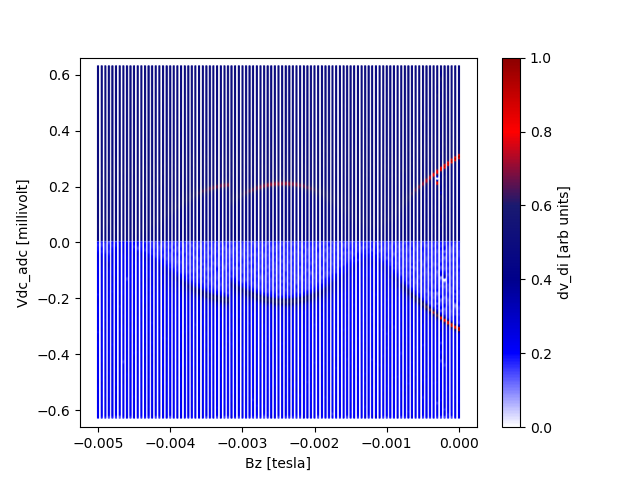

In [85]:
click_tolerance = 0.0002

def top_textbox_submission(text):
    global scan_number_top, scans_information
    try:
        # Determine which scan instance to use
        for scan_top in scans_information:
            if(scan_top["name_root"] == scan_names_to_analyze[scan_number_top]):
                break
        # Update Vortex Count
        temp = int(text.value)
        scan_top["initial_vortex"] = temp
        render_plot()
    except Exception as e:
        print(e)
        
def bottom_textbox_submission(text):
    global scan_number_top, scans_information
    try:
        # Determine which scan instance to use
        for scan_bottom in scans_information:
            if(scan_bottom["name_root"] == scan_names_to_analyze[scan_number_bottom]):
                break
        # Update Vortex Count
        # Update Vortex Count
        temp = int(text.value)
        scan_bottom["initial_vortex"] = temp
        render_plot()
    except Exception as e:
        print(e)

def mag_hyst_submission_top(text):
    global scan_number_top, scans_information
    try:
        # Determine which scan instance to use
        for scan_top in scans_information:
            if(scan_top["name_root"] == scan_names_to_analyze[scan_number_top]):
                break
        # Update magnetic hysteresis
        temp = float(text.value)
        scan_top["mag_hyst"] = temp
        #Move the boundary lines
        scan_top["vortex_splits"] = np.delete(scan_top["vortex_splits"], 0)
        scan_top["vortex_splits"] = np.delete(scan_top["vortex_splits"], -1)
        x_start_top = scan_top["first_var"]["min"] - scan_top["mag_hyst"]
        x_end_top = scan_top["first_var"]["max"] - scan_top["mag_hyst"]
        scan_top["vortex_splits"] = np.concatenate((scan_top["vortex_splits"], np.array([x_start_top])))
        scan_top["vortex_splits"] = np.concatenate((scan_top["vortex_splits"], np.array([x_end_top])))
        if(x_start_top > x_end_top):
            scan_top["vortex_splits"] = np.sort(scan_top["vortex_splits"])[::-1]#Sort descending
        else:
            scan_top["vortex_splits"] = np.sort(scan_top["vortex_splits"])#Sort ascending
        render_plot()
    except Exception as e:
        print(e)
        
def mag_hyst_submission_bottom(text):
    global scan_number_bottom, scans_information
    try:
        # Determine which scan instance to use
        for scan_bottom in scans_information:
            if(scan_bottom["name_root"] == scan_names_to_analyze[scan_number_bottom]):
                break
        # Update magnetic hysteresis
        temp = float(text.value)
        scan_bottom["mag_hyst"] = temp
        #Move the boundary lines
        scan_bottom["vortex_splits"] = np.delete(scan_bottom["vortex_splits"], 0)
        scan_bottom["vortex_splits"] = np.delete(scan_bottom["vortex_splits"], -1)
        x_start_bottom = scan_bottom["first_var"]["min"] - scan_bottom["mag_hyst"]
        x_end_bottom = scan_bottom["first_var"]["max"] - scan_bottom["mag_hyst"]
        scan_bottom["vortex_splits"] = np.concatenate((scan_bottom["vortex_splits"], np.array([x_start_bottom])))
        scan_bottom["vortex_splits"] = np.concatenate((scan_bottom["vortex_splits"], np.array([x_end_bottom])))
        if(x_start_bottom > x_end_bottom):
            scan_bottom["vortex_splits"] = np.sort(scan_bottom["vortex_splits"])[::-1]#Sort descending
        else:
            scan_bottom["vortex_splits"] = np.sort(scan_bottom["vortex_splits"])#Sort ascending
        render_plot()
    except Exception as e:
        print(e)
        
def top_next_action(b):
    global scan_number_top, scan_names_to_analyze, fig, ax
    if(scan_number_top < len(scan_names_to_analyze) - 1):
        scan_number_top = scan_number_top + 1
    render_plot()
    
def top_previous_action(b):
    global scan_number_top, scan_names_to_analyze, fig, ax
    if(scan_number_top > 0):
        scan_number_top = scan_number_top - 1
    render_plot()
        
def bottom_next_action(b):
    global scan_number_bottom, scan_names_to_analyze, fig, ax
    if(scan_number_bottom < len(scan_names_to_analyze) - 1):
        scan_number_bottom = scan_number_bottom + 1
    render_plot()

    
def bottom_previous_action(b):
    global scan_number_bottom, scan_names_to_analyze, fig, ax
    if(scan_number_bottom > 0):
        scan_number_bottom = scan_number_bottom - 1
    render_plot()

def add_vortex_labels_split(scan_top, scan_bottom):
    global fig, ax, labels
    for text in ax.texts:
        text.set_visible(False)

    x_start_top = scan_top["first_var"]["min"]
    x_end_top = scan_top["first_var"]["max"]
    
    label_xs_top = np.convolve(scan_top["vortex_splits"], np.ones(2), 'valid')/2 #Basically a moving average [1,4,6,20] -> [2,5,13]
    for label_i, label_x in enumerate(label_xs_top):
        if x_start_top < x_end_top:
            multiplier = 1 # Increasing field
        else:
            multiplier = -1 # Decreasing field
        label = ax.text(
            label_x, 0.5, str(scan_top["initial_vortex"] + label_i*multiplier),
            fontsize=12,
            color="black",
            ha='center', va='center',
            bbox=dict(facecolor="yellow", edgecolor='none', alpha=1)
        )
        labels.append(label)
        
    x_start_bottom = scan_bottom["first_var"]["min"]
    x_end_bottom = scan_bottom["first_var"]["max"]
    
    label_xs_bottom = np.convolve(scan_bottom["vortex_splits"], np.ones(2), 'valid')/2 #Basically a moving average [1,4,6,20] -> [2,5,13]
    for label_i, label_x in enumerate(label_xs_bottom):
        if x_start_bottom < x_end_bottom:
            multiplier = 1 # Increasing field
        else:
            multiplier = -1 # Decreasing field
        label = ax.text(
            label_x, -0.5, str(scan_bottom["initial_vortex"] + label_i*multiplier),
            fontsize=12,
            color="black",
            ha='center', va='center',
            bbox=dict(facecolor="yellow", edgecolor='none', alpha=1)
        )
        labels.append(label)
    
def render_plot():
    global scan_number_top, scan_number_bottom, scans_information, scan_names_to_analyze, label_top, label_bottom, fig, ax, mag_hyst_top, mag_hyst_bottom
    
    # Determine which scan instance to use
    for scan_top in scans_information:
        if(scan_top["name_root"] == scan_names_to_analyze[scan_number_top]):
            break
    for scan_bottom in scans_information:
        if(scan_bottom["name_root"] == scan_names_to_analyze[scan_number_bottom]):
            break
    
    # Plot the background di_dv plots
    if(fig is None):
        fig, ax, plot_elements = plot_scan_var_iv_split(scan_top, scan_bottom, logging=False)
        ax.set_title("")
        plt.show()
        #Also initialize vortex_splits, initial_vortex
        
    else:
        ax.clear()
        fig, ax, plot_elements = plot_scan_var_iv_split(scan_top, scan_bottom, fig=fig, ax=ax, logging=False)
        ax.set_title("")
        
    # Add vertical lines
    y_min = -0.65
    y_max = 0.65
    for x_pos in scan_top["vortex_splits"]:
        line = Line2D([x_pos, x_pos], [0, y_max], color='red', linewidth=4)
        ax.add_line(line)
    for x_pos in scan_bottom["vortex_splits"]:
        line = Line2D([x_pos, x_pos], [0, y_min], color='red', linewidth=4)
        ax.add_line(line)

    # Add vortex labels
    add_vortex_labels_split(scan_top, scan_bottom)
    
    # Update plot nums
    label_top.value = "Top Plot #: " + str(scan_number_top)
    label_bottom.value = "Bottom Plot #: " + str(scan_number_bottom)
    
    #Update vortex_num entry boxes
    text_box_top.value = str(scan_top["initial_vortex"])
    text_box_bottom.value = str(scan_bottom["initial_vortex"])
    
    #Update magnetic hysteresis entry
    mag_hyst_top.value = str(scan_top["mag_hyst"])
    mag_hyst_bottom.value = str(scan_bottom["mag_hyst"])
    
    # Save the updated vortex_splits and initial_vortex; anything displayed should be saved
    for scan_number in range(0, len(scan_names_to_analyze)):
        for scan in scans_information:
            if(scan["name_root"] == scan_names_to_analyze[scan_number]):
                save_vortex_labeling(extracted_data_base_dir, scan)
                
    fig.canvas.draw_idle()

def on_canvas_click(event):
    global scan_number_top, scan_number_bottom, scans_information, scan_names_to_analyze, fig, ax
    if event.inaxes != ax:
        return
    
    # Determine which scan instance to use
    for scan_top in scans_information:
        if(scan_top["name_root"] == scan_names_to_analyze[scan_number_top]):
            break
    for scan_bottom in scans_information:
        if(scan_bottom["name_root"] == scan_names_to_analyze[scan_number_bottom]):
            break
    
    if event.button == 1:  # Left click
        x_pos = event.xdata
        y_pos = event.ydata
        if(y_pos > 0):
            scan_top["vortex_splits"] = np.concatenate((scan_top["vortex_splits"], np.array([x_pos])))
            x_start_top = scan_top["first_var"]["min"]
            x_end_top = scan_top["first_var"]["max"]
            if(x_start_top > x_end_top):
                scan_top["vortex_splits"] = np.sort(scan_top["vortex_splits"])[::-1]#Sort descending
            else:
                scan_top["vortex_splits"] = np.sort(scan_top["vortex_splits"])#Sort ascending
        else:
            scan_bottom["vortex_splits"] = np.concatenate((scan_bottom["vortex_splits"], np.array([x_pos])))
            x_start_bottom = scan_bottom["first_var"]["min"]
            x_end_bottom = scan_bottom["first_var"]["max"]
            if(x_start_bottom > x_end_bottom):
                scan_bottom["vortex_splits"] = np.sort(scan_bottom["vortex_splits"])[::-1]#Sort descending
            else:
                scan_bottom["vortex_splits"] = np.sort(scan_bottom["vortex_splits"])#Sort ascending
        
    elif event.button == 3:  # Right click
        x_pos = event.xdata
        y_pos = event.ydata
        if(y_pos > 0):
            for i, split in enumerate(scan_top["vortex_splits"]):
                if(i == 0 or i == len(scan_top["vortex_splits"])-1):
                    continue
                if abs(x_pos - split) < click_tolerance:
                    scan_top["vortex_splits"] = np.delete(scan_top["vortex_splits"], i)
                    break
        else:
            for i, split in enumerate(scan_bottom["vortex_splits"]):
                if(i == 0 or i == len(scan_bottom["vortex_splits"])-1):
                    continue
                if abs(x_pos - split) < click_tolerance:
                    scan_bottom["vortex_splits"] = np.delete(scan_bottom["vortex_splits"], i)
                    break
    render_plot()
        
labels = []   
        
scan_number_top = 0
scan_number_bottom = 0

# Initial vortex splits and counts
extracted_data_base_dir = os.getcwd() + "/extracted_data/"
for scan_number in range(0, len(scan_names_to_analyze)):
    for scan in scans_information:
        if(scan["name_root"] == scan_names_to_analyze[scan_number]):
            #Load vortex_splits and initial_vortex from file if it exists. If not, generate it.
            scan["vortex_splits"], scan["initial_vortex"], scan["mag_hyst"], scan["fraunhofer_xlim_top"], scan["fraunhofer_ylim_top"], scan["fraunhofer_filepath_top"], scan["fraunhofer_xlim_bottom"], scan["fraunhofer_ylim_bottom"], scan["fraunhofer_filepath_bottom"] = load_vortex_labeling(extracted_data_base_dir, scan)

fig=None

text_box_top = widgets.Text(value="0", description='Top Initial Ct:', layout=widgets.Layout(width='200px', height='25px'), style={'description_width': 'initial'})
text_box_bottom = widgets.Text(value="0", description='Bottom Initial Ct:', layout=widgets.Layout(width='200px', height='25px'), style={'description_width': 'initial'})

mag_hyst_top = widgets.Text(value="0", description='Top Magnetic Hysteresis:', layout=widgets.Layout(width='300px', height='25px'), style={'description_width': 'initial'})
mag_hyst_bottom = widgets.Text(value="0", description='Bottom Magnetic Hysteresis:', layout=widgets.Layout(width='300px', height='25px'), style={'description_width': 'initial'})

top_forward_button = widgets.Button(description='Top Next Plot', style=widgets.ButtonStyle(button_color='lightblue', font_weight='bold'), layout=widgets.Layout(width='200px', height='25px'))
top_backward_button = widgets.Button(description='Top Previous Plot', style=widgets.ButtonStyle(button_color='lightblue', font_weight='bold'), layout=widgets.Layout(width='200px', height='25px'))
bottom_forward_button = widgets.Button(description='Bottom Next Plot', style=widgets.ButtonStyle(button_color='lightblue', font_weight='bold'), layout=widgets.Layout(width='200px', height='25px'))
bottom_backward_button = widgets.Button(description='Bottom Previous Plot', style=widgets.ButtonStyle(button_color='lightblue', font_weight='bold'), layout=widgets.Layout(width='200px', height='25px'))

label_top = widgets.Label(value="Top Plot #: " + str(scan_number_top), layout=widgets.Layout(width='200px', height='25px'))
label_bottom = widgets.Label(value="Bottom Plot #: " + str(scan_number_bottom), layout=widgets.Layout(width='200px', height='25px'))

field_entry_box_top = widgets.HBox([text_box_top, mag_hyst_top])
field_entry_box_bottom = widgets.HBox([text_box_bottom, mag_hyst_bottom])

button_box_top = widgets.HBox([top_backward_button, top_forward_button, label_top])
button_box_bottom = widgets.HBox([bottom_backward_button, bottom_forward_button, label_bottom])

text_box_top.on_submit(top_textbox_submission)
text_box_bottom.on_submit(bottom_textbox_submission)
mag_hyst_top.on_submit(mag_hyst_submission_top)
mag_hyst_bottom.on_submit(mag_hyst_submission_bottom)
top_forward_button.on_click(top_next_action)
top_backward_button.on_click(top_previous_action)
bottom_forward_button.on_click(bottom_next_action)
bottom_backward_button.on_click(bottom_previous_action)

render_plot()
fig.canvas.mpl_connect('button_press_event', on_canvas_click)

display(field_entry_box_top)
display(field_entry_box_bottom)
display(button_box_top)
display(button_box_bottom)
fig.set_size_inches(11, 6)


In [79]:
line_placement_tolerance = 0.0003 #Tesla around line placement to ignore when compiling data

separation_started_html = f"""
<div style="font-size: 24px; font-weight: bold; line-height: 1.5; text-align: center;">
    Separating ic curves by vortex count using line tolerance of {line_placement_tolerance} ...
</div>
"""

display(HTML(separation_started_html))

jumpless_fraunhofers = {}
jumpless_fraunhofers["measured_counts"] = []
jumpless_fraunhofers["fraunhofer_data"] = []
for i in range(len(scan_names_to_analyze)):
    for scan in scans_information:
        if(scan["name_root"] == scan_names_to_analyze[i]):
            break
            
    # Check direction of scan
    x_start = scan["first_var"]["min"]
    x_end = scan["first_var"]["max"]
    if x_start < x_end:
        multiplier = 1 # Increasing field
    else:
        multiplier = -1 # Decreasing field
            
    #  Extract the Ic curves from the raw data
    ic_neg, ic_pos = calculate_ic_trace(scan, threshold=0.01, logging=False)
    applied_b = np.linspace(scan["first_var"]["min"], scan["first_var"]["max"], scan["first_var"]["pts"])

    # for each of the vortex counts in the scan:
    for i, vortex_count in enumerate(range(scan["initial_vortex"], scan["initial_vortex"] + multiplier * (len(scan["vortex_splits"])-1), multiplier)):
    
        # If this is the first portion of the fraunhofer cooresponding to n-vortices, initialize the data structure
        if(not(vortex_count in jumpless_fraunhofers["measured_counts"])):
            jumpless_fraunhofers["measured_counts"].append(vortex_count)
            fraunhofer_data = {}
            fraunhofer_data["b"] = np.array([])
            fraunhofer_data["Ic_pos"] = np.array([])
            fraunhofer_data["Ic_neg"] = np.array([])
            jumpless_fraunhofers["fraunhofer_data"].append(fraunhofer_data)
        
        # Get the instance of fraunhofer_data corresponding to the number of vortices currently being analyzed
        fraunhofer_data = jumpless_fraunhofers["fraunhofer_data"][jumpless_fraunhofers["measured_counts"].index(vortex_count)]
        
        # Add the portion of this ic scan corresponding to the vortex# to the trace
        vortex_mask = (np.array(applied_b) >= min(scan["vortex_splits"][i], scan["vortex_splits"][i+1]) + line_placement_tolerance) & (np.array(applied_b) <= max(scan["vortex_splits"][i], scan["vortex_splits"][i+1]) - line_placement_tolerance)
        fraunhofer_data["b"] = np.concatenate((fraunhofer_data["b"], np.array(applied_b)[vortex_mask] - scan["mag_hyst"]))
        fraunhofer_data["Ic_pos"] = np.concatenate((fraunhofer_data["Ic_pos"], np.array(ic_pos)[vortex_mask]))
        fraunhofer_data["Ic_neg"] = np.concatenate((fraunhofer_data["Ic_neg"], np.array(ic_neg)[vortex_mask]))
        
separation_complete_html = f"""
<div style="font-size: 24px; font-weight: bold; line-height: 1.5; text-align: center;">
    Complete
</div>
"""

display(HTML(separation_complete_html))

C:\Users\draid\AppData\Local\Temp\ipykernel_7040\1734417043.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(b_values, Ic_pos_values, color=colors[vortex_count], s=2, cmap="hsv")
C:\Users\draid\AppData\Local\Temp\ipykernel_7040\1734417043.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(b_values, Ic_neg_values, color=colors[vortex_count], s=2, cmap="hsv")


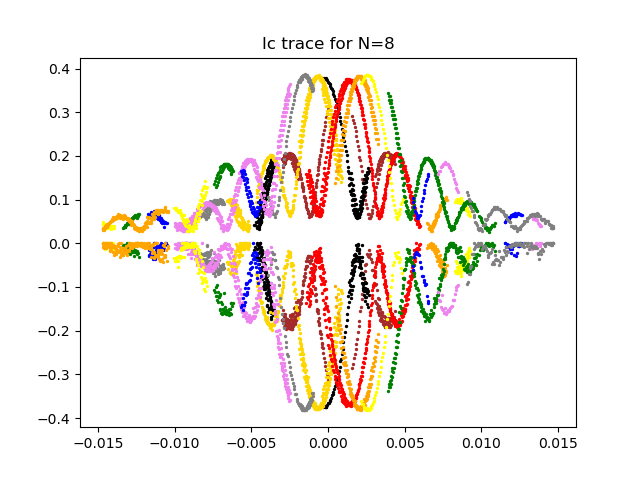

In [80]:
plt.close("all")
fig, ax = plt.subplots()

colors = ["black", "brown", "red", "orange", "yellow", "green", "blue", "violet", "grey", "gold"]
extracted_points = []

for vortex_count in jumpless_fraunhofers["measured_counts"]:
    
    fraunhofer_data = jumpless_fraunhofers["fraunhofer_data"][jumpless_fraunhofers["measured_counts"].index(vortex_count)]
    b_values = fraunhofer_data["b"]
    Ic_pos_values = fraunhofer_data["Ic_pos"]
    Ic_neg_values = fraunhofer_data["Ic_neg"]

    # Plot the fraunhofers
    ax.scatter(b_values, Ic_pos_values, color=colors[vortex_count], s=2, cmap="hsv")
    ax.scatter(b_values, Ic_neg_values, color=colors[vortex_count], s=2, cmap="hsv")

    # Prepare data for storage
    extracted_points.extend([(vortex_count, b, Ic) for b, Ic in zip(b_values, Ic_pos_values)])
    extracted_points.extend([(vortex_count, b, Ic) for b, Ic in zip(b_values, Ic_neg_values)])
    
    plt.title("Ic trace for N="+str(vortex_count))

plt.show()

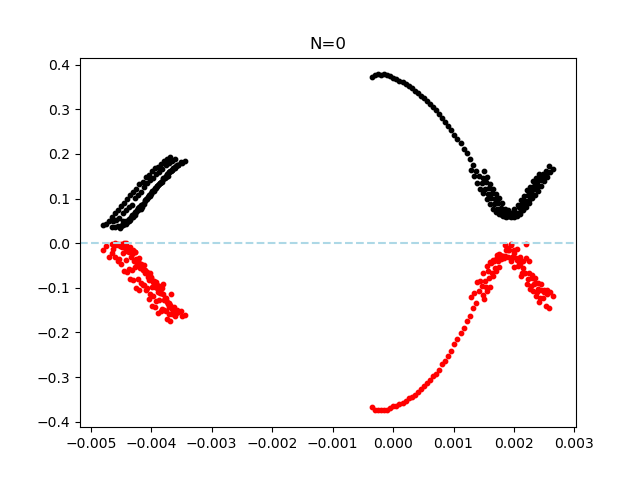

In [107]:
# Create a mapping of sorted index positions
sorted_indices = np.argsort(jumpless_fraunhofers["measured_counts"])
sorted_counts = np.array(jumpless_fraunhofers["measured_counts"])[sorted_indices]
index_mapping = {count: i for i, count in enumerate(sorted_counts)}

# Find the index closest to zero
closest_to_zero_index = index_mapping[sorted_counts[np.abs(sorted_counts).argmin()]]

# Initialize figure and axis
fig, ax = plt.subplots()

# List to store the vertical line positions
vertical_lines = []
v_shift = 0
flip_first_region = False

def apply_transformations(b_values, ic_pos_values, ic_neg_values, fraunhofer_data):
    global v_shift, vertical_lines, flip_first_region

    # Record the constant value and vertical lines
    fraunhofer_data["v_shift"] = v_shift
    fraunhofer_data["invert_xs"] = vertical_lines.copy()
    flip_first_region = fraunhofer_data["initial_invert"]
    
    if flip_first_region and not vertical_lines:
        new_ic_pos_values = -(np.copy(ic_pos_values) - v_shift) + v_shift
        new_ic_neg_values = -(np.copy(ic_neg_values) - v_shift) + v_shift
    else:
        new_ic_pos_values = np.copy(ic_pos_values)
        new_ic_neg_values = np.copy(ic_neg_values)
    
    if not vertical_lines:
        return new_ic_pos_values, new_ic_neg_values
    
    lines_sorted = sorted(vertical_lines)
    regions = np.searchsorted(lines_sorted, b_values)
    
    # Apply flipping transformations
    for i, region in enumerate(regions):
        factor = 1 if region % 2 == 0 else -1
        if flip_first_region:
            factor = -factor
        new_ic_pos_values[i] = factor * (new_ic_pos_values[i] - v_shift) + v_shift
        new_ic_neg_values[i] = factor * (new_ic_neg_values[i] - v_shift) + v_shift
    
    return new_ic_pos_values, new_ic_neg_values

def on_click(event):
    global vertical_lines
    if event.inaxes is not None:
        x = event.xdata
        if event.button == 1:  # Left click to add a vertical line
            vertical_lines.append(x)
        elif event.button == 3:  # Right click to remove a vertical line
            if vertical_lines:
                xlim = ax.get_xlim()
                threshold = (xlim[1] - xlim[0]) * 0.05
                # Find the closest line to the clicked position
                closest_line = min(vertical_lines, key=lambda line: abs(line - x))
                if abs(closest_line - x) <= threshold:
                    vertical_lines.remove(closest_line)
        update_plot(current_index)

def update_plot(sorted_index):
    global vertical_lines, v_shift

    # Clear previous plot elements
    ax.clear()
    
    # Get the current data index and plot data
    original_index = sorted_indices[sorted_index]
    vortex_count = jumpless_fraunhofers["measured_counts"][original_index]
    fraunhofer_data = jumpless_fraunhofers["fraunhofer_data"][original_index]

    b_values = np.array(fraunhofer_data["b"])
    ic_pos_values = np.array(fraunhofer_data["Ic_pos"])
    ic_neg_values = np.array(fraunhofer_data["Ic_neg"])

    # Apply transformations based on vertical lines and constant value
    new_ic_pos_values, new_ic_neg_values = apply_transformations(b_values, ic_pos_values, ic_neg_values, fraunhofer_data)

    fraunhofer_data["Ic_pos_new"] = new_ic_pos_values
    fraunhofer_data["Ic_neg_new"] = new_ic_neg_values
    
    # Plotting transformed values
    ax.scatter(b_values, new_ic_pos_values, color="black", s=10, label="Ic_pos_new")
    ax.scatter(b_values, new_ic_neg_values, color="red", s=10, label="Ic_neg_new")

    # Plotting the vertical lines
    for x in vertical_lines:
        ax.axvline(x=x, color='blue', linestyle='--')

    # Plotting the horizontal constant line
    ax.axhline(y=v_shift, color='lightblue', linestyle='--')

    ax.set_title(f"N={vortex_count}")

    min_y = min(min(new_ic_pos_values), min(new_ic_neg_values))
    max_y = max(max(new_ic_pos_values), max(new_ic_neg_values))
    ax.set_ylim(min_y * 1.1, max_y * 1.1)
    
    constant_text.value = str(v_shift)
    flip_toggle.value = fraunhofer_data["initial_invert"]
    
    plt.draw()
        
# Function to update the constant value
def update_v_shift(change):
    global v_shift
    try:
        v_shift = float(change['new'])
    except ValueError:
        v_shift = 0
    update_plot(current_index)

# Function to toggle the flip of the first region
def toggle_flip(change):
    global flip_first_region, sorted_indices, jumpless_fraunhofers
    fraunhofer_data = jumpless_fraunhofers["fraunhofer_data"][sorted_indices[current_index]]
    fraunhofer_data["initial_invert"] = change['new']
    update_plot(current_index)

# Initial plot
current_index = closest_to_zero_index
update_plot(current_index)
plt.show()

# Button callback functions
def on_next_button_clicked(_):
    global current_index, vertical_lines, v_shift, jumpless_fraunhofers, flip_first_region
    if current_index < len(sorted_counts) - 1:
        current_index += 1
        # Reset vertical lines and constant value
        vertical_lines = jumpless_fraunhofers["fraunhofer_data"][sorted_indices[current_index]].get("invert_xs", [])
        flip_first_region = jumpless_fraunhofers["fraunhofer_data"][sorted_indices[current_index]].get("initial_invert", 0)
        v_shift = jumpless_fraunhofers["fraunhofer_data"][sorted_indices[current_index]].get("v_shift", 0)
        update_plot(current_index)

def on_prev_button_clicked(_):
    global current_index, vertical_lines, v_shift, jumpless_fraunhofers, flip_first_region
    if current_index > 0:
        current_index -= 1
        # Reset vertical lines and constant value
        vertical_lines = jumpless_fraunhofers["fraunhofer_data"][sorted_indices[current_index]].get("invert_xs", [])
        flip_first_region = jumpless_fraunhofers["fraunhofer_data"][sorted_indices[current_index]].get("initial_invert", 0)
        v_shift = jumpless_fraunhofers["fraunhofer_data"][sorted_indices[current_index]].get("v_shift", 0)
        update_plot(current_index)
        
# Create widgets
constant_text = widgets.FloatText(description='Constant:', value=0)
constant_text.observe(update_v_shift, names='value')

flip_toggle = widgets.ToggleButton(
    value=False,
    description='Flip First Region',
    style={'button_color': 'lightgreen'}
)
flip_toggle.observe(toggle_flip, names='value')

next_button = widgets.Button(description="Next", style=widgets.ButtonStyle(button_color='lightblue', font_weight='bold'))
prev_button = widgets.Button(description="Previous", style=widgets.ButtonStyle(button_color='lightblue', font_weight='bold'))

next_button.on_click(on_next_button_clicked)
prev_button.on_click(on_prev_button_clicked)

# Connecting the click event
fig.canvas.mpl_connect('button_press_event', on_click)

# Display widgets
display(widgets.VBox([constant_text, flip_toggle, widgets.HBox([prev_button, next_button])]))

C:\Users\draid\AppData\Local\Temp\ipykernel_7040\587986010.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(b_values, Ic_pos_values, color=colors[vortex_count], s=2, cmap="hsv")


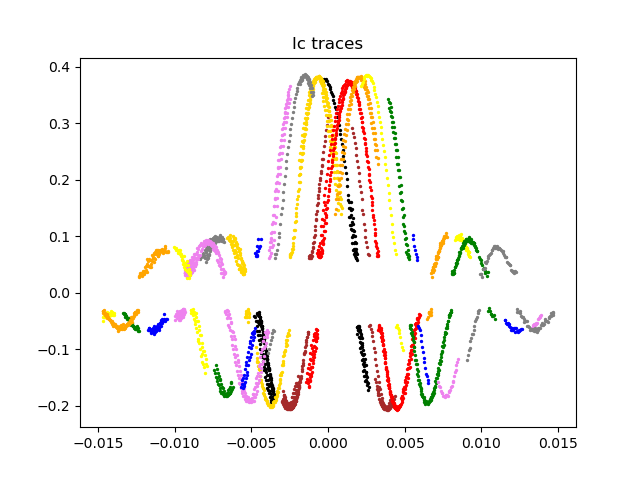

Data saved to D:\Documents\0Purdue\Research\Rokhinson Lab\CPR-Extraction/extracted_data/extracted_points.h5


In [108]:
plt.close("all")
fig, ax = plt.subplots()

colors = ["black", "brown", "red", "orange", "yellow", "green", "blue", "violet", "grey", "gold"]
extracted_points = []

for vortex_count in jumpless_fraunhofers["measured_counts"]:
    

    fraunhofer_data = jumpless_fraunhofers["fraunhofer_data"][jumpless_fraunhofers["measured_counts"].index(vortex_count)]
    b_values = fraunhofer_data["b"]
    Ic_pos_values = fraunhofer_data.get("Ic_pos_new", None)
    Ic_neg_values = fraunhofer_data.get("Ic_neg_new", None)

    # Plot the fraunhofers
    if(Ic_pos_values is None):
        print("Vortex (N=" + str(vortex_count) + ") has not been subdivided")
    else:
        ax.scatter(b_values, Ic_pos_values, color=colors[vortex_count], s=2, cmap="hsv")
        #         ax.scatter(b_values, Ic_neg_values, color=colors[vortex_count], s=2, cmap="hsv")

        # Only store the positive values (ramping from neg to pos, sample heating, retrapping, etc)
        extracted_points.extend([(vortex_count, b, Ic) for b, Ic in zip(b_values, Ic_pos_values)])
        #         extracted_points.extend([(vortex_count, b, Ic) for b, Ic in zip(b_values, Ic_neg_values)])

        plt.title("Ic traces")

plt.show()

# Convert the list of tuples to a structured numpy array
dtype = [('N', 'i4'), ('B', 'f4'), ('ic', 'f4')]
structured_array = np.array(extracted_points, dtype=dtype)

points_filepath = os.getcwd() + "/extracted_data/extracted_points.h5"

with h5py.File(points_filepath, 'w') as points_fid:
    points_fid.create_dataset('tuples', data=structured_array)

print("Data saved to " + points_filepath)

In [98]:
points_filepath = os.getcwd() + "/extracted_data/extracted_points.h5"
with h5py.File(points_filepath, 'r') as f:
    # Read the data into a numpy array
    structured_array = f['tuples'][:]

# Convert the numpy array back to a list of tuples
list_of_tuples = [tuple(row) for row in structured_array]

print("Data loaded from 'data.h5'")
print(list_of_tuples)

Data loaded from 'data.h5'
[(3, 0.006651675, 0.039), (3, 0.00670165, 0.028), (3, 0.006751625, 0.035), (3, 0.0068016, 0.028), (3, 0.006851575, 0.037), (3, 0.00690155, 0.041), (3, 0.006951525, 0.05), (3, 0.0070015, 0.047), (3, 0.007051475, 0.0535), (3, 0.00710145, 0.0595), (3, 0.007151425, 0.0635), (3, 0.0072014, 0.064), (3, 0.007251375, 0.0735), (3, 0.00730135, 0.0805), (3, 0.007351325, 0.0845), (3, 0.0074013, 0.085), (3, 0.007451275, 0.0905), (3, 0.00750125, 0.0875), (3, 0.007551225, 0.098), (3, 0.0076012, 0.0985), (3, 0.007651175, 0.0985), (3, 0.00770115, 0.101), (3, 0.0031429878, 0.2395), (3, 0.0030921951, 0.253), (3, 0.0030414024, 0.263), (3, 0.0029906097, 0.272), (3, 0.002939817, 0.2825), (3, 0.0028890243, 0.2915), (3, 0.0028382316, 0.3005), (3, 0.002787439, 0.3105), (3, 0.0027366464, 0.3185), (3, 0.0026858537, 0.3275), (3, 0.002635061, 0.3345), (3, 0.0025842683, 0.343), (3, 0.0025334756, 0.348), (3, 0.002482683, 0.354), (3, 0.0024318902, 0.36), (3, 0.0023810975, 0.365), (3, 0.0023

In [35]:
plt.close("all")